In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
import random

# Filtered categories
TARGET_LABELS = ['person', 'car', 'bird', 'traffic light', 'cell phone']

# Create a mapping of category IDs to sequential indices
class COCODataset(Sequence):
    def __init__(self, images_dir, annotations_file, batch_size, input_size, target_labels, max_samples={'person': 7000, 'car': 6000}):
        self.images_dir = images_dir
        self.coco = COCO(annotations_file)
        self.batch_size = batch_size
        self.input_size = input_size

        # Get category IDs for target labels
        self.target_cat_ids = self.coco.getCatIds(catNms=target_labels)
        self.cat_id_to_index = {cat_id: idx + 1 for idx, cat_id in enumerate(self.target_cat_ids)}
        self.cat_id_to_index[0] = 0  # For the background class

        # Collect image IDs for each target label
        self.image_ids = []
        self.image_counts = {}

        for label in target_labels:
            cat_id = self.coco.getCatIds(catNms=[label])[0]
            img_ids = self.coco.getImgIds(catIds=cat_id)
            
            # Limit the number of images for 'person' and 'car' categories
            if label in max_samples:
                img_ids = random.sample(img_ids, min(len(img_ids), max_samples[label]))
            
            self.image_ids.extend(img_ids)
            self.image_counts[label] = len(img_ids)

        # Remove duplicates
        self.image_ids = list(set(self.image_ids))

        # Print counts
        for label, count in self.image_counts.items():
            print(f"Number of images with label '{label}': {count}")
        print(f"Total images: {len(self.image_ids)}")

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.image_ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for img_id in batch_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.images_dir, img_info['file_name'])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.input_size)

            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.target_cat_ids)
            anns = self.coco.loadAnns(ann_ids)
            mask = np.zeros(self.input_size, dtype=np.uint8)

            for ann in anns:
                segmentation = self.coco.annToMask(ann)
                segmentation = cv2.resize(segmentation, self.input_size, interpolation=cv2.INTER_NEAREST)
                # Map the original category_id to the sequential index
                mapped_label = self.cat_id_to_index[ann['category_id']]
                mask = np.maximum(mask, segmentation * mapped_label)

            images.append(image / 255.0)
            masks.append(mask)

        return np.array(images), np.array(masks)


# Parameters
train_images_dir = "D:\\cs675finalproject\\train2017" 
train_annotations_file = "D:\\cs675finalproject\\annotations\\instances_train2017.json"
batch_size = 8
input_size = (256, 256)

# Initialize Dataset and Model
train_dataset = COCODataset(train_images_dir, train_annotations_file, batch_size, input_size, TARGET_LABELS)


loading annotations into memory...
Done (t=15.29s)
creating index...
index created!
Number of images with label 'person': 7000
Number of images with label 'car': 6000
Number of images with label 'bird': 3237
Number of images with label 'traffic light': 4139
Number of images with label 'cell phone': 4803
Total images: 22390


In [2]:
# Callback to Store Accuracy and Loss per Step
class StepMetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.accuracies = []
        self.steps = []

    def on_train_batch_end(self, batch, logs=None):
        # Collect data after each step
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.steps.append(len(self.losses))

    def on_train_end(self, logs=None):
        # Plot loss and accuracy at the end of training
        plt.figure(figsize=(12, 5))
        plt.suptitle('Training Progress')

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.steps, self.losses, color='red', label='Loss')
        plt.title('Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.steps, self.accuracies, color='blue', label='Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

In [3]:
# U-Net Model Definition
def unet_model(input_size=(256, 256, 3), num_classes=len(TARGET_LABELS)+1):  # 5 target labels + 1 background
    inputs = layers.Input(input_size)

    # Downsampling path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Upsampling path
    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.concatenate([u2, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.concatenate([u1, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c5)

    model = Model(inputs, outputs)
    return model

model = unet_model(input_size=(256, 256, 3), num_classes=len(TARGET_LABELS) + 1)  # +1 for background class
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,883,462 (7.18 MB)

 Trainable params: 1,883,462 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


d:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2799/2799 ━━━━━━━━━━━━━━━━━━━━ 13740s 5s/step - accuracy: 0.8437 - loss: 0.5589
Epoch 2/5
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 12825s 5s/step - accuracy: 0.8494 - loss: 0.4660
Epoch 3/5
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 12814s 5s/step - accuracy: 0.8584 - loss: 0.4350
Epoch 4/5
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 12876s 5s/step - accuracy: 0.8674 - loss: 0.4082
Epoch 5/5
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 12941s 5s/step - accuracy: 0.8692 - loss: 0.4000


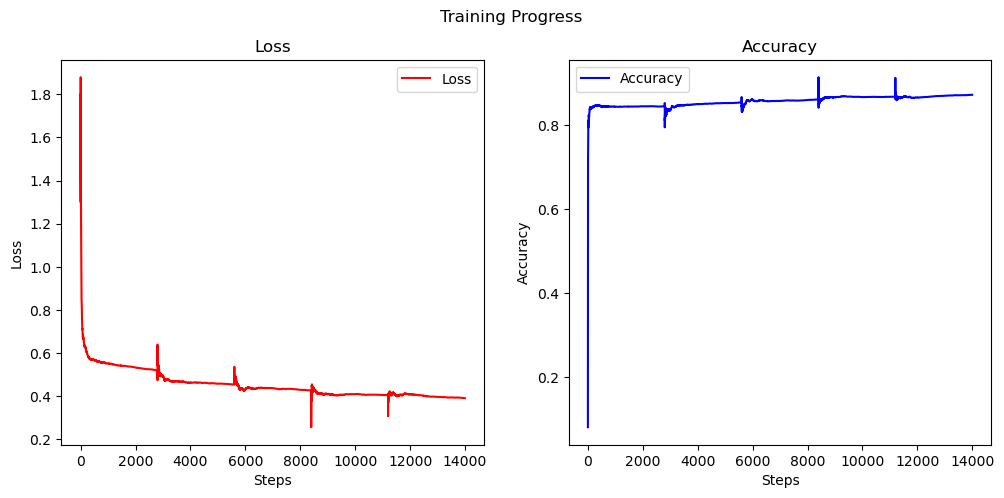

In [4]:
# Train the model
step_metrics_logger = StepMetricsLogger()
epochs = 5
history = model.fit(train_dataset, epochs=epochs, callbacks=[step_metrics_logger])

In [ ]:
# Save Model
model.save("D:\\cs675finalproject\\model.keras")

In [5]:
# Test Dataset Class with Category Filtering and Limited Samples
class TestCOCODataset(Sequence):
    def __init__(self, images_dir, annotations_file, batch_size, input_size, target_labels, max_samples_per_label=200):
        self.images_dir = images_dir
        self.coco = COCO(annotations_file)
        self.batch_size = batch_size
        self.input_size = input_size

        # Get category IDs for target labels
        self.target_cat_ids = self.coco.getCatIds(catNms=target_labels)
        self.cat_id_to_index = {cat_id: idx + 1 for idx, cat_id in enumerate(self.target_cat_ids)}
        self.cat_id_to_index[0] = 0  # For the background class

        # Collect image IDs for each target label, limited to max_samples_per_label
        self.image_ids = []
        self.image_counts = {}

        for label in target_labels:
            cat_id = self.coco.getCatIds(catNms=[label])[0]
            img_ids = self.coco.getImgIds(catIds=cat_id)
            img_ids = random.sample(img_ids, min(len(img_ids), max_samples_per_label))
            self.image_ids.extend(img_ids)
            self.image_counts[label] = len(img_ids)

        # Remove duplicates
        self.image_ids = list(set(self.image_ids))

        # Print counts
        for label, count in self.image_counts.items():
            print(f"Number of images with label '{label}': {count}")
        print(f"Total test images: {len(self.image_ids)}")

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.image_ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for img_id in batch_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.images_dir, img_info['file_name'])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.input_size)

            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.target_cat_ids)
            anns = self.coco.loadAnns(ann_ids)
            mask = np.zeros(self.input_size, dtype=np.uint8)

            for ann in anns:
                segmentation = self.coco.annToMask(ann)
                segmentation = cv2.resize(segmentation, self.input_size, interpolation=cv2.INTER_NEAREST)
                mapped_label = self.cat_id_to_index[ann['category_id']]
                mask = np.maximum(mask, segmentation * mapped_label)

            images.append(image / 255.0)
            masks.append(mask)

        return np.array(images), np.array(masks)

In [6]:
# Parameters for the test dataset
test_images_dir = "D:\\cs675finalproject\\val2017"  # Replace with the path to your test images
test_annotations_file = "D:\\cs675finalproject\\annotations\\instances_val2017.json"  # Replace with your test annotation file
batch_size = 8
input_size = (256, 256)

# Initialize the test dataset
test_dataset = TestCOCODataset(test_images_dir, test_annotations_file, batch_size, input_size, TARGET_LABELS, max_samples_per_label=200)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
Number of images with label 'person': 200
Number of images with label 'car': 200
Number of images with label 'bird': 125
Number of images with label 'traffic light': 191
Number of images with label 'cell phone': 200
Total test images: 835


In [ ]:
# Evaluate the model
from tensorflow.keras.models import load_model

# Load model
loaded_model = load_model("D:\\cs675finalproject\\model.keras")

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


105/105 ━━━━━━━━━━━━━━━━━━━━ 102s 967ms/step - accuracy: 0.8708 - loss: 0.3927
Test Loss: 0.4052
Test Accuracy: 0.8682


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


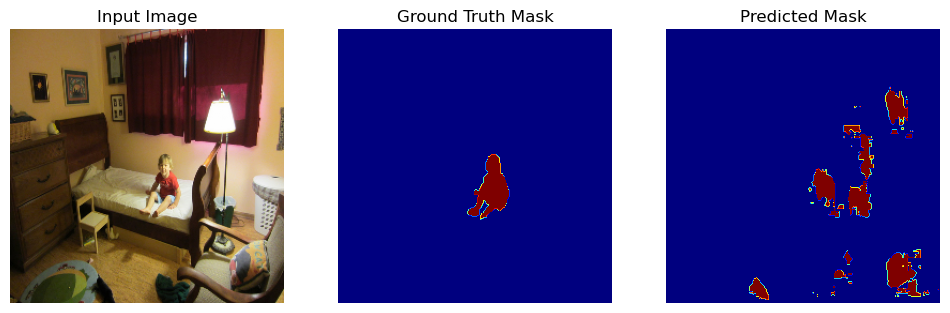

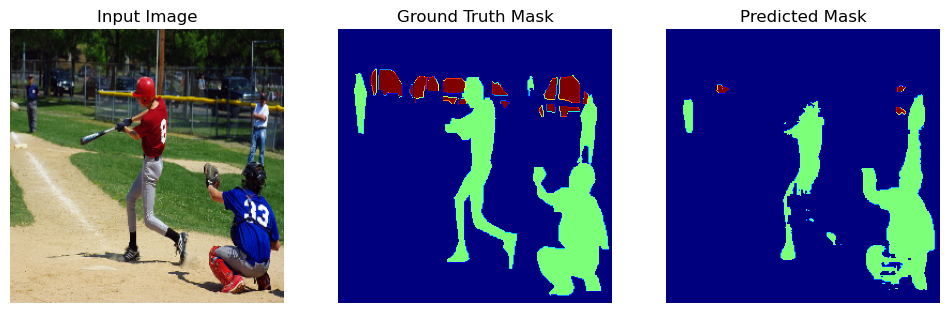

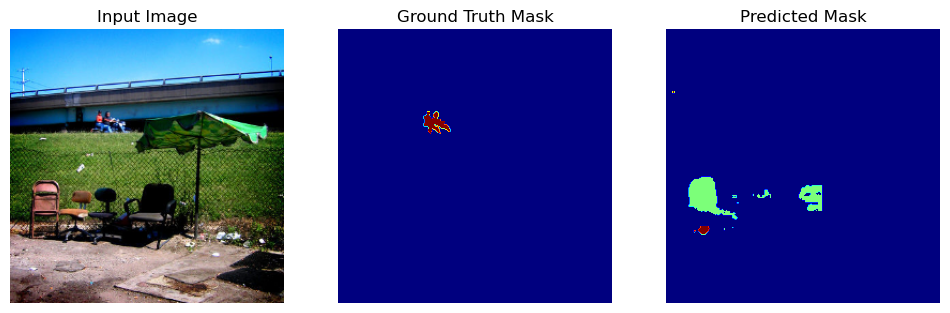

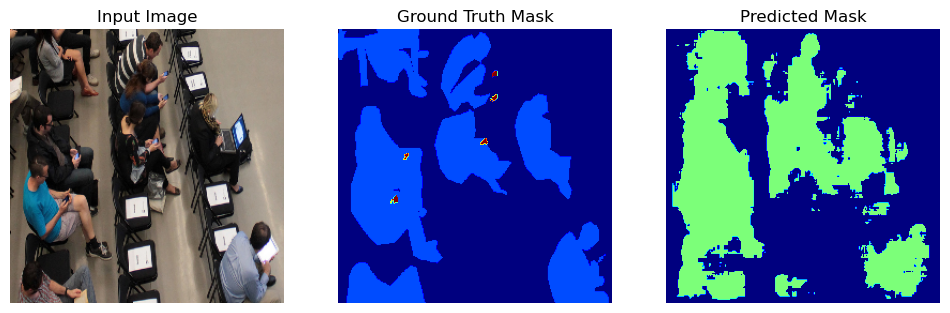

In [11]:
import matplotlib.pyplot as plt
import random

# Get a random batch of images and masks from the test dataset
images, true_masks = test_dataset[random.randint(0, len(test_dataset) - 1)]

# Get model predictions
pred_masks = loaded_model.predict(images)

# Plot the results for 4 random images
num_images_to_plot = 4
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(images[i])
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_masks[i], cmap='jet')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(np.argmax(pred_masks[i], axis=-1), cmap='jet')
    plt.axis('off')

    plt.show()
